#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path = '/content/drive/MyDrive/project1/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * features.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [3]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv('./data01_train.csv')
test_data = pd.read_csv('./data01_test.csv')
features = pd.read_csv('./features.csv')

In [4]:
#불필요한 칼럼을 삭제하세요.
drop_columns = ['subject']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)

#### 2) 기본 정보 조회

In [6]:
#전체 데이터의 행,열 개수 확인
train_data.shape, test_data.shape

((5881, 562), (1471, 562))

In [7]:
#전체 데이터의 상위 5개 행 확인
train_data.head(10)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.599906,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.371055,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.258503,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.052863,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING
9,0.275352,0.011248,-0.048331,-0.973058,-0.842016,-0.726302,-0.975582,-0.843670,-0.746247,-0.917813,...,0.494164,0.299404,0.051630,-0.002736,0.427852,-0.730449,-0.816355,0.217058,-0.028260,STANDING


In [8]:
#전체 데이터의 수치형 변수 분포 확인
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [9]:
#전체 데이터의 모든 변수 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
#Label 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
train_data['is_dynamic'] = np.where(train_data['Activity'].isin(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']),1,0)
test_data['is_dynamic'] = np.where(test_data['Activity'].isin(['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']),1,0)

### (2) x, y 분리

In [16]:
#x,y 분리하기
x = train_data.drop(columns=['Activity','is_dynamic'])
y1 = train_data['Activity']
y2 = train_data['is_dynamic']
X_test = test_data.drop(columns=['Activity','is_dynamic'])
y1_test = test_data['Activity'] 
y2_test = test_data['is_dynamic']

### (3) 데이터 분할
* train, val 분할

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y1_train, y1_val, y2_train, y2_val = train_test_split(
                                                        x, y1, y2, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y1)
x_train.shape, x_val.shape, y1_train.shape, y1_val.shape, y2_train.shape, y2_val.shape

((4704, 561), (1177, 561), (4704,), (1177,), (4704,), (1177,))

### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
le = LabelEncoder()
y1 = le.fit_transform(y1)
y1_test = le.transform(y1_test) 

In [18]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_test = scaler.fit_transform(X_test)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [38]:
clear_session()

#모델링(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
model1 = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),   
    Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,257 (313.50 KB)

 Trainable params: 80,257 (313.50 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# 컴파일 및 학습
model1.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')

hist = model1.fit(x_train, y2_train, validation_split = 0.2, epochs=20, batch_size=64, verbose=0)

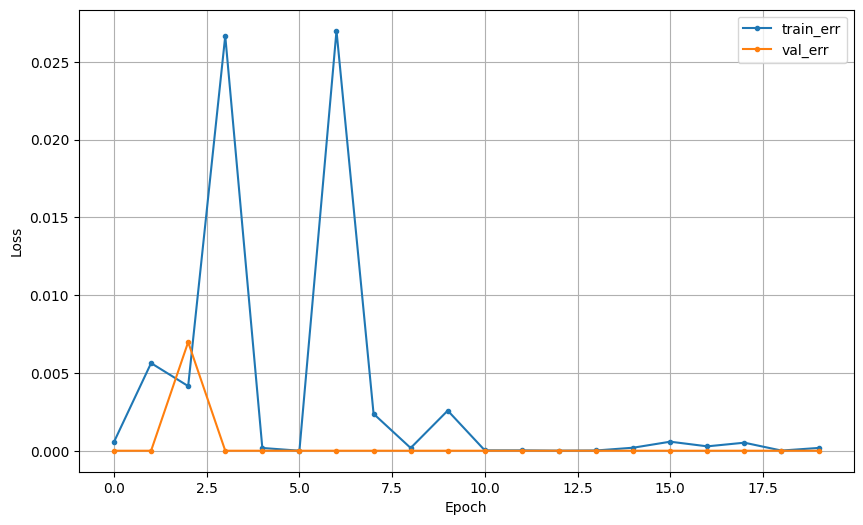

In [47]:
# 학습곡선
dl_history_plot(hist.history)


In [ ]:
# 예측 및 평가
y_pred = model1.predict(x_val)
y_pred = np.where(y_pred>0.5,1,0)
print(classification_report(y2_val, y_pred))


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# (tip) 정적 행동(0)인 데이터 추출
x_static = x_train[y2_train==0]
y1_static = y1_train[y2_train==0]

In [50]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑핑
activity_map = {label:idx for idx, label in enumerate(le.classes_)}
activity_map

{'LAYING': 0,
 'SITTING': 1,
 'STANDING': 2,
 'WALKING': 3,
 'WALKING_DOWNSTAIRS': 4,
 'WALKING_UPSTAIRS': 5}

In [51]:
# 모델 설계
clear_session()
model2 = Sequential([
    Input(shape=(x_static.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),   
    Dense(len(activity_map), activation='softmax')
])

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,582 (314.77 KB)

 Trainable params: 80,582 (314.77 KB)

 Non-trainable params: 0 (0.00 B)

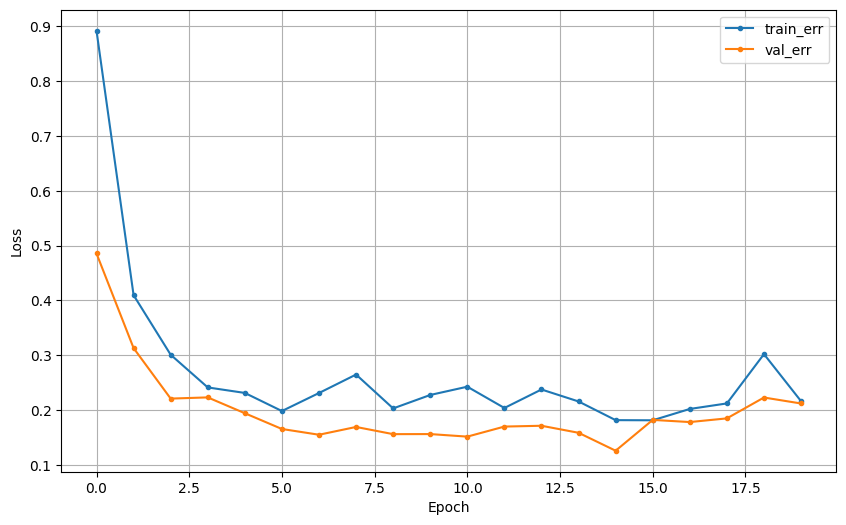

In [53]:
# 컴파일 및 학습
model2.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')

hist = model2.fit(x_static, y1_static, validation_split = 0.2, epochs=20, batch_size=64, verbose=0)
# 학습곡선
dl_history_plot(hist.history)

In [64]:
y1_val[y2_val==0].shape 

(647,)

In [66]:
# 예측 및 평가
y_pred = np.argmax(model2.predict(x_val[y2_val==0]), axis=-1)

# static activity labels (Laying, Sitting, Standing)
static_labels = sorted(np.unique(y1_val[y2_val==0]))
static_names = [le.classes_[i] for i in static_labels]

print(classification_report(y1_val[y2_val==0], y_pred, target_names=static_names))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       223
     SITTING       0.81      1.00      0.90       206
    STANDING       0.99      0.79      0.88       218

    accuracy                           0.93       647
   macro avg       0.94      0.93      0.92       647
weighted avg       0.94      0.93      0.93       647



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [56]:
# (tip) 동적 행동(1)인 데이터 추출
x_dynamic = x_train[y2_train==1]
y1_dynamic = y1_train[y2_train==1]

In [58]:
# (tip) map 활용해서 숫자레이블로 매핑핑
activity_map = {label:idx for idx, label in enumerate(le.classes_)}
activity_map

{'LAYING': 0,
 'SITTING': 1,
 'STANDING': 2,
 'WALKING': 3,
 'WALKING_DOWNSTAIRS': 4,
 'WALKING_UPSTAIRS': 5}

In [59]:
# 모델 설계
clear_session()

model3 = Sequential([
    Input(shape=(x_dynamic.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),   
    Dense(len(activity_map), activation='softmax')
])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,582 (314.77 KB)

 Trainable params: 80,582 (314.77 KB)

 Non-trainable params: 0 (0.00 B)

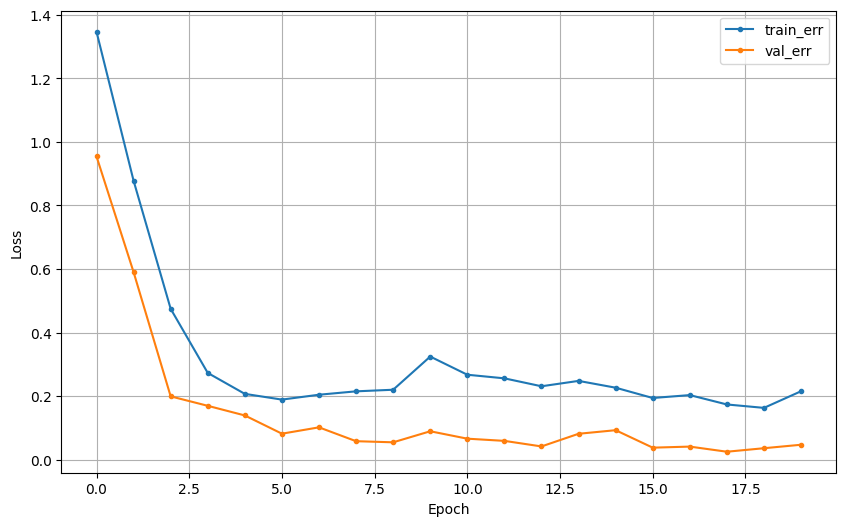

In [ ]:
# 컴파일 및 학습
model3.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')

hist = model3.fit(x_dynamic, y1_dynamic, validation_split= 0.2, epochs=20, batch_size=64, verbose=0)

# 학습곡선
dl_history_plot(hist.history)

In [63]:
# 예측 및 평가
y_pred = np.argmax(model3.predict(x_val[y2_val==1]), axis=1)

# dynamic activity labels (Walking, Walking Upstairs, Walking Downstairs)
dynamic_labels = sorted(np.unique(y1_val[y2_val==1]))
dynamic_names = [le.classes_[i] for i in dynamic_labels]

print(classification_report(y1_val[y2_val==1], y_pred, target_names=dynamic_names))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
                    precision    recall  f1-score   support

           WALKING       0.97      0.99      0.98       200
WALKING_DOWNSTAIRS       0.95      0.99      0.97       158
  WALKING_UPSTAIRS       0.99      0.92      0.95       172

          accuracy                           0.97       530
         macro avg       0.97      0.97      0.97       530
      weighted avg       0.97      0.97      0.97       530



### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

def predict_and_evaluate(x, y1, y2):
    # 1. 전처리
    # 1-1. 스케일링
    x = scaler.fit_transform(x)
    
    # 2. 예측하기
    # 2-1. 단계1을 모델로 0,1 구분
    y2_pred = model1.predict(x)
    y2_pred = np.where(y2_pred>0.5,1,0)
    
    # 2-2. 단계 1의 결과로 데이터 나누기
    x_static = x[y2_pred.flatten()==0]
    x_dynamic = x[y2_pred.flatten()==1]
    
    # 2-3. 단계2 모델로 예측
    y1_static_pred = np.argmax(model2.predict(x_static), axis=-1)
    y1_dynamic_pred = np.argmax(model3.predict(x_dynamic), axis=1)
    
    # 2-4. 예측 결과 원래 값으로 변환
    static_labels = sorted(np.unique(y1[y2==0]))
    static_names = [le.classes_[i] for i in static_labels]
    
    dynamic_labels = sorted(np.unique(y1[y2==1]))
    dynamic_names = [le.classes_[i] for i in dynamic_labels]
    
    print("Static Activity Classification Report")
    print(classification_report(y1[y2==0], y1_static_pred, target_names=static_names))
    
    print("Dynamic Activity Classification Report")
    print(classification_report(y1[y2==1], y1_dynamic_pred, target_names=dynamic_names))
    
    # 2-5. 하나로 합쳐보기
    y1_pred = np.empty_like(y1)
    y1_pred[y2_pred.flatten()==0] = y1_static_pred
    y1_pred[y2_pred.flatten()==1] = y1_dynamic_pred
    
    # 3. 최종 성능평가 하기
    print("Overall Activity Classification Report")
    all_activity_labels = sorted(np.unique(y1))
    all_activity_names = [le.classes_[i] for i in all_activity_labels]
    
    print(classification_report(y1, y1_pred, target_names=all_activity_names))

In [74]:
y1_test.unique()

array(['SITTING', 'STANDING', 'WALKING', 'WALKING_UPSTAIRS', 'LAYING',
       'WALKING_DOWNSTAIRS'], dtype=object)

In [ ]:
X_test = test_data.drop(columns=['Activity','is_dynamic'])
y1_test = test_data['Activity'] 
y2_test = test_data['is_dynamic']

predict_and_evaluate(X_test, y2_test, y1_test)

In [ ]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Activation
import tensorflow as tf

# 모델 설계
clear_session()

nfeatures = x_train.shape[1]

inputs = Input(shape=(nfeatures,), name='inputs')
x = Dense(128, activation='relu', name='trunk_dense1')(inputs)
x = Dropout(0.3, name='trunk_dropout1')(x)
x = Dense(64, activation='relu', name='trunk_dense2')(x)
x = Dropout(0.3, name='trunk_dropout2')(x)

# dyn head
dyn_logit = Dense(1, name='is_dynamic_logit')(x)
dyn_prob  = Activation('sigmoid', name='is_dynamic')(dyn_logit)  # 출력 이름 지정

# act head depends on dyn
concat = Concatenate(name='concat_act_feats')([x, dyn_prob])     # x + dyn을 입력으로 사용
act_out = Dense(6, activation='softmax', name='activity')(concat)

class_model = Model(inputs=inputs, outputs=[act_out, dyn_prob], name='act_depends_on_dyn')


class_model.summary()

Model: "act_depends_on_dyn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 561)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trunk_dense1        │ (None, 128)       │     71,936 │ inputs[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trunk_dropout1      │ (None, 128)       │          0 │ trunk_dense1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trunk_dense2        │ (None, 64)        │      8,256 │ trunk_dropout1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trunk_dropout2      │ (None, 64)        │          0 │ trunk_dense2[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ is_dynamic_logit    │ (None, 1)         │         65 │ trunk_dropout2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ is_dynamic          │ (None, 1)         │          0 │ is_dynamic_logit… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_act_feats    │ (None, 65)        │          0 │ trunk_dropout2[0… │
│ (Concatenate)       │                   │            │ is_dynamic[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity (Dense)    │ (None, 6)         │        396 │ concat_act_feats… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 80,653 (315.05 KB)

 Trainable params: 80,653 (315.05 KB)

 Non-trainable params: 0 (0.00 B)

#### 2) test 셋으로 예측하고 평가하기

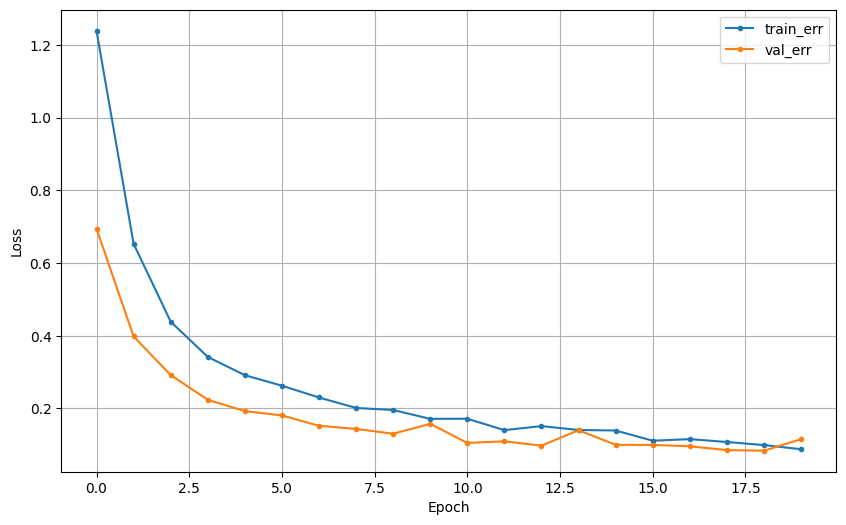

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Activity Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       223
           SITTING       0.82      0.98      0.90       206
          STANDING       0.99      0.80      0.89       218
           WALKING       0.99      1.00      1.00       200
WALKING_DOWNSTAIRS       0.99      0.99      0.99       158
  WALKING_UPSTAIRS       0.99      0.98      0.99       172

          accuracy                           0.96      1177
         macro avg       0.96      0.96      0.96      1177
      weighted avg       0.96      0.96      0.96      1177

Is_Dynamic Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.0

In [ ]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기
class_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'activity': 'sparse_categorical_crossentropy', 'is_dynamic': 'binary_crossentropy'},
    metrics={'activity': ['accuracy'],
             'is_dynamic': [tf.keras.metrics.AUC(name='auc'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall')]},
    loss_weights={'activity': 1.0, 'is_dynamic': 0.5}
)

hist = class_model.fit(
    x_train, {'activity': y1_train, 'is_dynamic': y2_train},
    validation_split=0.2,
    epochs=20, batch_size=64, verbose=0
)

dl_history_plot(hist.history)

# 예측 및 평가
y1_pred_prob, y2_pred_prob = model1.predict(x_val)
y1_pred = np.argmax(y1_pred_prob, axis=1)
#y2_pred = (y2_pred_prob > 0.5).astype(int)  # 이진 분류의 경우 임계값 0.5 사

y2_pred = (y2_pred_prob > 0.5).astype(int)  # 이진 분류의 경우 임계값 0.5 사용


print('Activity Classification Report')
print(classification_report(y1_val, y1_pred, target_names=le.classes_))
print('Is_Dynamic Classification Report')
print(classification_report(y2_val, y2_pred))